# Spectrum Sensing II (Sparse Recovery with LASSO)

## Looking Ahead

In the previous example, we examined the simulated spectral occupancy data in the frequency domain and identified the presence of sparsity. Our techniques for examining the frequency occupancies were analogous to "classical" digital methods for spectrum sensing that you might have learned in an undergraduate communications class: one samples at a sufficiently high rate to acquire the entire frequency domain signal, then examines frequency bands of interest.

In this exercise, we will instead employ a compressive architecture for spectrum sensing, given that there is frequency sparsity present. This sensing architecture will allow us to sample the signal at a drastically lower rate than the full Nyquist sampling frequency while still being able to reconstruct the frequency occupancies. Please check the homework handout for a more precise writeup of the compressive receiver architecture that we simulate here.


## Downloading the Data and Preparing It

We download the data file from my Github page again. Then we process it to obtain the zero-one occupancy matrix from the previous homework (code taken from the solutions). Check the previous notebook for the descriptions of the different parameters.

**Note**: We are using a different data file in this homework. Instead of white gaussian signal, we use audio signals from $\href{https://www.upf.edu/web/mtg/irmas}{\text{IRMAS}}$ dataset. Signals in certain time slots would be a music piece of certain instruments. 

In [1]:
!git clone https://github.com/tykswtr/instr_ss

fatal: destination path 'instr_ss' already exists and is not an empty directory.


In [0]:
import scipy.io as sio
import scipy.signal as ssig
import numpy as np
import numpy.matlib
import bokeh.plotting as bpl
import matplotlib.pyplot as plt
from IPython.display import Audio

D = sio.loadmat('/content/instr_ss/ss_instr2_1.mat', squeeze_me=True)

## Move dictionary vars into locals
B = D['B']
Nslots = D['Nslots']
Nuser = D['Nuser']
SNR = D['SNR']
fmin = D['fmin']
fs = D['fs']
slot_time = D['slot_time']
x = D['x']
subband_occupancy = D['subband_occupancy']

## Derived parameters
fmax = Nuser * B + fmin
T = slot_time * Nslots
Nsamp = len(x)
slot_dur = Nsamp // Nslots
## Time and frequency axes
f_axis = fs * np.arange(-Nsamp/2+1, Nsamp/2+1)/Nsamp
t_axis = Nslots * slot_time * np.arange(0, Nsamp)/Nsamp
f_axis = np.squeeze(f_axis)
t_axis = np.squeeze(t_axis)

In [0]:
## Compute bin edges
freq_edges = np.arange(fmin, fmax+B, B) # for in-band
slot_edges = np.arange(0, Nsamp + 1, slot_dur)
slot_f_axis = f_axis[::Nslots]

def freq_power_detector(slot_idx):
  # Expect slot_idx in 0, 1, ..., Nslots-1
  slot_x = x[slot_edges[slot_idx]:slot_edges[slot_idx+1]]
  slot_X = np.fft.fftshift(np.fft.fft(slot_x))
  freq_occupancy_powers = np.zeros((Nuser,))
  for band_idx in range(Nuser):
    subband_mask = np.where((slot_f_axis >= freq_edges[band_idx]) 
                            & (slot_f_axis <= freq_edges[band_idx+1]))[0]
    # occupancy = slot_X[subband_mask]
    freq_occupancy_powers[band_idx] = np.mean(20 * np.log10(np.absolute(slot_X[subband_mask])))
  return freq_occupancy_powers

## Make the 0-1 matrix
raw_powers = np.zeros((Nslots, Nuser))
for slot_idx in range(Nslots):
  raw_powers[slot_idx, :] = freq_power_detector(slot_idx)
  
thresh = 30
up_idx = np.where((raw_powers > thresh))
down_idx = np.where((raw_powers <= thresh))
occupancies = np.zeros((Nslots, Nuser))
occupancies[up_idx] = 1
occupancies[down_idx] = 0
  
subband_sparsities = np.sum(occupancies, axis=1)
slot_sparsities = np.sum(occupancies, axis=0)

In [0]:
slot1_x = x[0:slot_dur]
slot1_X = np.fft.fftshift(np.fft.fft(slot1_x))
## We need to downsample the frequency axis to match the shorter slot time
slot_f_axis = f_axis[::Nslots]

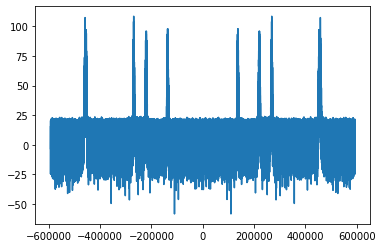

In [5]:
# We can view the sparsity in the frequency domain
plt.plot(slot_f_axis, 20 * np.log10(np.absolute(slot1_X)))

In [6]:
# From the occupacy matrix above, we notice that 55th slot is occupied, let's view its frequency content
idx_u = 54;
f_center = fmin + idx_u*B + B/2;
subband_mask = np.where((slot_f_axis >= f_center-4*B)
                           & (slot_f_axis <= f_center+4*B))[0]

bpl.output_notebook()
h = bpl.figure(title="Frequency-domain signal x")
h.xaxis.axis_label = 'Frequency (MHz)'
h.yaxis.axis_label = 'Power (dB)'
h.line(slot_f_axis[subband_mask] * 1e-6,
       20 * np.log10(np.absolute(slot1_X[subband_mask])))
bpl.show(h)

In [7]:
# Given x, we are able to show one subband music by passing it through a low band pass filter
# We first modulate it to move its frequency around 0 
user_id = 54;
f_center = fmin + user_id*B + B/2;
t_axis = slot_time * np.arange(0, slot_dur)/slot_dur
osc_sigs = np.cos(-2 * np.pi * f_center * t_axis);
mod_sub_slot1_x = osc_sigs*slot1_x;

# Then pass it through a low pass filter
[b, a] = ssig.cheby1(5, 1, B/fs);
lp_sub_slot1_x = ssig.lfilter(b, a, mod_sub_slot1_x);

# Downsample to get signal back
audio_sub_slot1_x = lp_sub_slot1_x[::int(fs/B/2)];
Audio(audio_sub_slot1_x,rate=2*B)

## Receiver Implementation

In this section, we provide an implementation of the compressive receiver architecture we described in the homework writeup. The number of receiver channels is a parameter that we will be able to modify. We also give the sensing matrix A that corresponds to the receiver, based on our mathematical model for the receiver and used for doing sparse recovery. Note however that the receiver itself is implemented using DSP routines.

First, we create the sensing matrix based on the frequency domain system model we discussed in the homework writeup.

In [0]:
## Set receiver size and sampling parameters
m = 64
L = int(np.floor(fmax / B))
n = 2*L + 1

## Create random sign (Rademacher) matrix
S = (np.random.rand(m, n) > 0.5).astype(int)
S = 2 * S - 1
## Create system coefficient array
## Try it a faster way
F = np.fft.fft(np.eye(n))
F_reshaped = np.concatenate((F[:, L+1:], F[:, :L+1]), axis=1)
d = np.zeros((n,)).astype(np.complex64)
for idx_l in range(n):
  l_shifted = -L + idx_l
  if l_shifted == 0:
    d_coeff = 1/n  
  else:
    d_coeff = 1/(1j*2*np.pi*l_shifted)*(1 - np.exp(-1j*2*np.pi*l_shifted/n))
  d[idx_l] = d_coeff
D = np.diag(d)
C = np.dot(np.dot(S, F_reshaped), D)

## Create sensing matrix
A = np.conj(C)

Next, we implement the receiver's action on our input signal using DSP routines. Since we are performing a digital simulation, our low-pass antialiasing filter is not ideal; we try to make it as close as possible to ideal by using many filter coefficients, and we also change the rate (decimate) after filtering for efficiency.

In [0]:
## Implement the sign-alternating mixing functions.
## Given our choices, these signals have rate nB, which can be shown equals fs. (nyquist rate)
## So we don't need to interpolate anything: just periodically extend.
p_seqs = np.matlib.repmat(S, 1, int(len(x)/n))
# Mix the input with the sign-alternating functions.
x_mix = x * p_seqs
# Design the low pass filters. For efficiency, just use a single filter for all branches.
ds_factor = int(fs/B)
x_ds = ssig.decimate(x_mix, ds_factor, ftype='fir', axis=1)
y = ds_factor * x_ds  # Preserve approximately the energy of original signal

We have a downsampling rate close to the user number. This large reduction in samples was possible because each user's bandwidth is very small compared to the maximum frequency in the multiplexing scheme.

Note, however, that the rate of the mixing sequences is required to be very high: equal to the Nyquist rate, in fact. In applications at the GHz scale, this may not be feasible. More modern compressive receiver architectures than the one we implement here exist, which address this problem.

### A Key Implementation Point

Note that the measurement matrix `A` we have generated does **not** have number of columns equal to `Nuser`: it actually has `2*Nuser + 13` columns. This is because our receiever has a low-pass architecture: it resolves the entire frequency spectrum from `-fmax` to `fmax`, so in particular it contains two elements for each positive frequency band in our band of interest `[fmin, fmax]`! It also contains **extra** bands' frequency content, in particular the spectrum from `-fmin` to `fmin`, which accounts for the extra `13` columns.

It is very important to take this into account below, when doing detection tasks with your LASSO recovery algorithm. In particular, you should look at both the first `128` and the last `128` elements of the output vector in order to see what the frequency occupancies are in our band of interest.

In [10]:
A.shape

(64, 269)

## Signal Recovery

We now have our measurements from the receiver `y`, and our model of the linear mapping implemented by the receiver `A`. We can solve the LASSO problem using the proximal gradient algorithm, as described in the homework writeup, in order to attempt to recover the original spectral occupancies.

As input to the LASSO algorithm, we need to give a single measured vector y, but for each slot we have numerous samples in our output `y` created above. In this assignment, we will use a naive approach to doing this: we create a single input for the LASSO solver by simply taking a random summation over the `slot_dur_ds` vectors in `y`. 

In [0]:
# For our tasks belowe, we try to focus on the first slot. You can change the code to work on other slots
slot_idx = 0
slot_dur_ds = int(slot_dur / ds_factor)
y_slot = y[:, slot_dur_ds*slot_idx:slot_dur_ds*(slot_idx+1)]

true_occupancies = occupancies[slot_idx, :] # Our ground-truth occupancies, for assessment

## random summation and the true X

As we mentioned in the homework handout, we can consider $Y(f) = A X(f)$, where $X(f)$ is sparse. In practice, it would be more efficient if we are able to deal with time domain signal $y$ which is the same $y$ we have in the code. However, our measurement $y$ have the same length as downsampled $x$, and maybe we don't want to put everying in our Lasso solver directly. What we do here is some naive projection. Assume $r$ is a random complex gaussian, then You can consider our measurement `lasso_input_y` as $\text{lasso_input_y} = Y(f) F r = A X(f) F r$, where $F$ is the inverse DFT matrix. As Fourier transfer preserves norm, we can consider $X(f)F$ also be sparse, and hope a random projection does not affect sparsity. 

In [0]:
# We take our lasso input as a random projection by mixing it with a complex gaussian noise
rand_pj = np.random.randn(y_slot.shape[-1], ) + 1j * np.random.randn(y_slot.shape[-1], )
lasso_input_y = y_slot.dot(rand_pj)

support of x: [ 30  31  73  83  84  85 103 165 183 184 185 195 237 238]


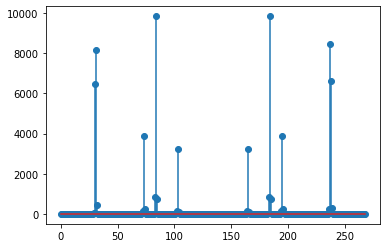

In [13]:
# Based on the logic above, we can try to visualize the sparsity of our true X 
slot_x = x[slot_edges[slot_idx]:slot_edges[slot_idx+1]]
slot_X = np.fft.fftshift(np.fft.fft(slot_x))
slot_MX = slot_X.reshape((-1, y_slot.shape[-1]));
slot_xx = np.fft.ifft(np.fft.ifftshift(slot_MX, axes=1))
true_x = np.dot(slot_xx, rand_pj)
x_supp = np.where(np.abs(true_x) > 1/10*np.max(true_x))[0]
plt.stem(np.abs(true_x), use_line_collection=True)
# You should tell that for most random projection, this should be (with high chance) consistent with occupacy matrix
print("support of x: {}".format(x_supp))

### Recovery of Signal After Knowing the Support

Our task here for spectrum sensing is mainly a support recovery. We care more about the support of our solution $x$ than its actual value. For many engineering applications, support recovery is of great importance. The goal is know which frequency bands are available, so that we can avoid interfering with other users. From above, we have shown one example how you can get the subband music through a low pass filter. Here we show another way to recovering the signal from our measurements directly. 

Notice that our `lasso_input_y` is only a random projection of the true signal, so it does not contains all the time domain information. To recover it, instead of running multiple sparse recovery problem, we can utilize the information of support. We know that $Y(f) = A X(f)$, where `A` is a wide $m \times n$ matrix and thus underermined. Once we are able to know the support, we can get $A_S$ by only chosing the columns our signal is supported on. Thus `A` becomes a $m \times k$ matrix, where $k$ is the size of the support. We can find our `X` by simply $X(f) = A^{\dagger} Y(f)$. Here $A^{\dagger}$ is the pseudo inverse. We try to show the example below:

In [14]:
# The below code is for slot 1 and band 55th, you can alter the code if want to listen to something different
tru_x_supp = np.array([30, 31, 73, 84, 103, 165, 184, 195, 237, 238])
A_tall = A[:, tru_x_supp]
A_tall_inv = np.linalg.pinv(A_tall)
pred_x = A_tall_inv.dot(y_slot)
# we can hear the music piece we have above directly through one channel
Audio(np.real(pred_x[-3, :]),rate=B)

## Your Tasks

Below, you are only required to complete the tasks for the **first slot**, using the variable `lasso_input_y` generated above. You can evaluate your algorithm for the other slots, too, if you want.

Complete each level three header below.

### Task 1: Implementing Proximal Gradient Descent for the LASSO Objective

Using the proximal gradient iteration given in the homework writeup (and after calculating and implementing the proximal operator for the scaled L1 norm yourself), write code to solve the LASSO problem to recover the frequency occupancies from the input data `lasso_input_y` and `A` that we generated with our simulated receiever above.

To check that your algorithm is working properly, it is a good idea to keep track of the objective value (equation (6) in the writeup) at each iteration. After you run your algorithm for the maximum number of iterations, plot the objective value and make sure it is decreasing and leveling off. If it isn't, your algorithm likely has a bug, or you need to run it for more iterations.

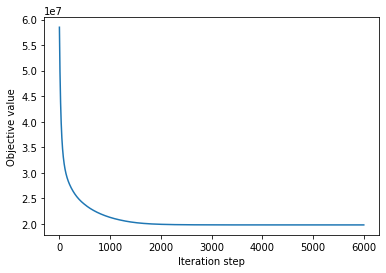

In [15]:
def prox(w, alpha):
  # the alpha in equ(1.6) actually is the alpha*lambda in Lasso problem
  # in practice, the alpha should be alpha*lambda = lambda / L
  x = np.zeros(w.shape[0],dtype = np.complex128)
  for i in range(w.shape[0]):
    if(np.linalg.norm(w[i]) <= alpha):
      x[i] = 0+0j
    else:
      x[i] = w[i] * (np.linalg.norm(w[i])-alpha) / np.linalg.norm(w[i])
  return x

def proximal_gradient(A, y, lamda, tolerance, maxstep):
  x = np.zeros(A.shape[1],dtype = np.complex128)
  obj_value = []
  L = np.linalg.norm(A) ** 2  # Lipschitz constant
  # initial iteration
  w = x - np.conjugate(A).T.dot(A.dot(x) - y)/L
  x = prox(w, lamda / L)
  obj = 0.5 * np.linalg.norm(A.dot(x) - y) ** 2 + lamda * np.linalg.norm(x, 1)
  obj_value.append(obj)
  # other iterations
  for i in range(1, maxstep):
    w = x - np.conjugate(A).T.dot(A.dot(x) - y)/L
    x = prox(w, lamda / L)
    obj = 0.5 * np.linalg.norm(A.dot(x) - y) ** 2 + lamda * np.linalg.norm(x, 1)
    obj_value.append(obj)
    if abs(obj - obj_value[i-1]) < tolerance:
      break
  return x, obj_value

lamda = 300
tolerance = 1e-4
maxstep = 6000

x_recover, obj_value = proximal_gradient(A, lasso_input_y, lamda, tolerance, maxstep)

plt.figure()
plt.plot(obj_value)
plt.xlabel('Iteration step')
plt.ylabel('Objective value')
plt.show()

# plt.plot(x_recover)
# plt.show()

### Task 2: Assessing the Detection Performance of our Recovery Algorithm

Now that you have an algorithm implemented for performing sparse recovery of the spectral occupancies, perform the following tasks to assess its performance:
1. Create a spectral occupancy detector by picking a fixed threshold value: entries in the vector `x` returned by your LASSO recovery algorithm that have powers (magnitude-squared) larger than the threshold correspond to bands that are "occupied", and those lower than the threshold are not. Using this threshold detector, convert your LASSO outputs to zero-one vectors. Remember to discard the entries that correspond to frequency bands outside our band of interest `[fmin, fmax]`.
2. Compute the error rate for your detector: this is the total number of false detection from your detector compared to the true occupacy matrix. 
3. Above, we set the variable `m` to determine the number of measurement branches in our system. repeat the above process a few (at least three) times for two different `m` of your choices (for example, `16`, `48`, `64`). What can you say about the result here?

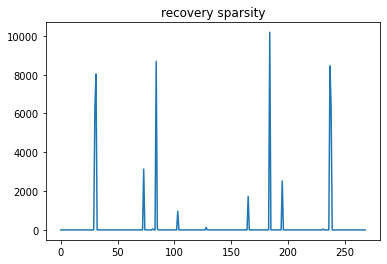



***********************All frequency range [-fmax, fmax]************************
----------------------------------Ground Truth----------------------------------
support: [30, 31, 73, 83, 84, 85, 103, 165, 183, 184, 185, 195, 237, 238]
-------------------------------Detected Recovery--------------------------------
number of the support: 9
support: [30, 31, 73, 84, 165, 184, 195, 237, 238]


*********************Interest frequency range [fmin, fmax]**********************
----------------------------------Ground Truth----------------------------------
occupancy [24, 43, 54, 96, 97]
-------------------------------Detected Recovery--------------------------------
occupancy [24, 43, 54, 96, 97]


error rate for detector: error detected 0, missed 0


********************************Result Analysis*********************************
When the value of 'm' increases, the recovery result becomes better. 
When the value of 'lambda' increases, the recovery result becomes more sparse


In [16]:
# 1
def threshold_detector(vector, threshold):
  raw = np.vectorize(lambda x:np.linalg.norm(x))(vector)
  first = raw[0:Nuser]
  last = raw[-Nuser:]
  return np.argwhere(first > threshold), np.argwhere(last > threshold), np.argwhere(raw > threshold)

plt.plot(np.vectorize(lambda x:np.linalg.norm(x))(x_recover))
plt.title('recovery sparsity')
plt.show()
first_index, last_index, raw_index = threshold_detector(x_recover, 1000)

print('\n')
print('All frequency range [-fmax, fmax]'.center(80,'*'))
print('Ground Truth'.center(80,'-'))
print('support:', list(x_supp))
print('Detected Recovery'.center(80,'-'))
print('number of the support:', len(raw_index))
print('support:', list(raw_index.flat))

print('\n')
print('Interest frequency range [fmin, fmax]'.center(80,'*'))
occupancy_true = [idx for idx, val in enumerate(true_occupancies) if val > 0]
print('Ground Truth'.center(80,'-'))
print('occupancy', occupancy_true)
print('Detected Recovery'.center(80,'-'))
print('occupancy', list(last_index.flat))
print('\n')

# 2
occupancy_detect = list(last_index.flat)
error = len(set(occupancy_detect) - set(occupancy_true))
miss = len(set(occupancy_true) - set(occupancy_detect))
print('error rate for detector: error detected {}, missed {}'.format(error, miss))

# 3
print('\n')
print('Result Analysis'.center(80,'*'))
print('When the value of \'m\' increases, the recovery result becomes better. \nWhen the value of \'lambda\' increases, the recovery result becomes more sparse')

# m = 32
# lambda    number of nonzero       index of nonzero
# 100       16                      [5] [39] [51] [73] [99] [103] [117] [118] [133] [150] [155] [165] [181] [195] [211] [219]
# 150       9                       [73] [103] [117] [118] [150] [165] [195] [211] [219]
# 200       7                       [73] [103] [117] [118] [150] [165] [195]
# 300       6                       [73] [103] [118] [150] [165] [195]
# 400       3                       [73] [165] [195]
# 500       3                       [73] [165] [195]
# 600       2                       [73] [195]
# 700       2                       [73] [195]
# 800       2                       [73] [195]
# 900       2                       [73] [195]
# 1000      2                       [73] [195]



# m = 16 result:
# ***********************All frequency range [-fmax, fmax]************************
# ----------------------------------Ground Truth----------------------------------
# support: [30, 31, 73, 84, 103, 165, 184, 195, 237, 238]
# -------------------------------Detected Recovery--------------------------------
# number of the support: 9
# support: [30, 31, 83, 89, 101, 127, 139, 163, 201]

# *********************Interest frequency range [fmin, fmax]**********************
# ----------------------------------Ground Truth----------------------------------
# occupancy [24, 43, 54, 96, 97]
# -------------------------------Detected Recovery--------------------------------
# occupancy [22, 60]

# error rate for detector: error detected 2, missed 5


# m = 32 result:
# ***********************All frequency range [-fmax, fmax]************************
# ----------------------------------Ground Truth----------------------------------
# support: [30, 31, 73, 84, 103, 165, 184, 195, 237, 238]
# -------------------------------Detected Recovery--------------------------------
# number of the support: 6
# support: [84, 103, 126, 151, 165, 184]

# *********************Interest frequency range [fmin, fmax]**********************
# ----------------------------------Ground Truth----------------------------------
# occupancy [24, 43, 54, 96, 97]
# -------------------------------Detected Recovery--------------------------------
# occupancy [10, 24, 43]

# error rate for detector: error detected 1, missed 3


# m = 48 result:
# ***********************All frequency range [-fmax, fmax]************************
# ----------------------------------Ground Truth----------------------------------
# support: [30, 31, 73, 83, 84, 85, 103, 165, 183, 184, 185, 195, 237, 238]
# -------------------------------Detected Recovery--------------------------------
# number of the support: 10
# support: [30, 31, 73, 84, 103, 165, 184, 195, 237, 238]

# *********************Interest frequency range [fmin, fmax]**********************
# ----------------------------------Ground Truth----------------------------------
# occupancy [24, 43, 54, 96, 97]
# -------------------------------Detected Recovery--------------------------------
# occupancy [24, 43, 54, 96, 97]

# error rate for detector: error detected 0, missed 0


# m = 64 result:
# ***********************All frequency range [-fmax, fmax]************************
# ----------------------------------Ground Truth----------------------------------
# support: [30, 31, 73, 84, 103, 165, 184, 195, 237, 238]
# -------------------------------Detected Recovery--------------------------------
# number of the support: 10
# support: [30, 31, 73, 84, 103, 165, 184, 195, 237, 238]

# *********************Interest frequency range [fmin, fmax]**********************
# ----------------------------------Ground Truth----------------------------------
# occupancy [24, 43, 54, 96, 97]
# -------------------------------Detected Recovery--------------------------------
# occupancy [24, 43, 54, 96, 97]

# error rate for detector: error detected 0, missed 0